In [1]:
%matplotlib inline

import os
import sys
import math
import tables as tb
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mp_colors

In [2]:
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.core.fit_functions as fitf
import antea.database.load_db              as db

from   invisible_cities.core .stat_functions    import poisson_sigma
from   invisible_cities.core .system_of_units_c import units
from   invisible_cities.io   .dst_io            import load_dst
from   invisible_cities.icaro.hst_functions     import hist
from   invisible_cities.icaro.hst_functions     import hist2d

In [3]:
## style
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   
    
blue         = tableau20[ 0]
green        = tableau20[ 4]
red          = tableau20[ 6]
pink         = tableau20[ 7]
purple       = tableau20[ 8]
light_purple = tableau20[ 9]
brown        = tableau20[10]
grey         = tableau20[15]

color_nice = '#029386'

plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 13, 11

colors = [blue, green, red, purple, brown, grey]
linestyle = ['-', '-.', ':','-','--', ':']

In [4]:
def get_weights(data, norm):
    if norm:
        return np.repeat(1.0/len(data), len(data))
    else:
        return np.repeat(1.0, len(data))

In [5]:
## functions to fit
def twogauss(x, amp0, mu0, sigma0, amp, mu, sigma):
    return  amp0/(2*np.pi)**.5/sigma0 * np.exp(-0.5*(x-mu0)**2./sigma0**2.) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def threegauss(x, amp0, mu0, sigma0, amp1, mu1, sigma1, amp, mu, sigma):
    return  amp0/(2*np.pi)**.5/sigma0 * np.exp(-0.5*(x-mu0)**2./sigma0**2.) + amp1/(2*np.pi)**.5/sigma1 * np.exp(-0.5*(x-mu1)**2./sigma1**2.) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def gauss(x, amp, mu, sigma):
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def exp(x, a0, tau):
    return a0 * np.exp(x/tau) 

def expgauss(x, a0, tau, amp, mu, sigma):
    return a0 * np.exp(x/tau) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

In [6]:
import textwrap
from invisible_cities.evm.ic_containers   import Measurement
from invisible_cities.icaro.hst_functions import measurement_string

def gtext(values, errors):
    """
    Build a string to be displayed within a matplotlib plot.
    """
    return textwrap.dedent("""
        $\mu$ = %.3f +/- %.3f mm
        $\sigma$ = %.3f +/- %.3f mm
        FWHM res. = %.3f mm
        """%(values[0] , errors[0],
             values[1] , errors[1], 2.35*values[1]))

def gtext_angle(values, errors):
    """
    Build a string to be displayed within a matplotlib plot.
    """
    return textwrap.dedent("""
        $\mu$ = %.3f +/- %.3f deg
        $\sigma$ = %.3f +/- %.3f deg
        FWHM res. = %.3f deg
        """%(values[0] , errors[0],
             values[1] , errors[1], 2.35*values[1]))

In [7]:
true_r1, true_phi1, true_z1 = [], [], []
reco_r1, reco_phi1, reco_z1 = [], [], []
true_r2, true_phi2, true_z2 = [], [], []
reco_r2, reco_phi2, reco_z2 = [], [], []
events = []
sns_response1, sns_response2 = [],[]
true_t1, true_t2 = [], []
sipm_t1, sipm_t2 = [], []
first_sipm1, first_sipm2 = [], []
phot1, phot2, phot_like1, phot_like2 = [], [], [], []
true_dep_e1, true_dep_e2 = [], []


filepath = '/data5/users/carmenromo/fastmc/data_extract_true_reco_info_full_body_exp_dist_tof/'

for filename in os.listdir(filepath):
    if filename.endswith('.npz'):
        my_file = filepath+filename
        d   = np.load(my_file)

        true_r1   = np.concatenate((true_r1,   d['a_true_r1']))
        true_phi1 = np.concatenate((true_phi1, d['a_true_phi1']))
        true_z1   = np.concatenate((true_z1,   d['a_true_z1']))   

        reco_r1   = np.concatenate((reco_r1,   d['a_reco_r1']))
        reco_phi1 = np.concatenate((reco_phi1, d['a_reco_phi1']))  
        reco_z1   = np.concatenate((reco_z1,   d['a_reco_z1']))  

        true_r2   = np.concatenate((true_r2,   d['a_true_r2']))
        true_phi2 = np.concatenate((true_phi2, d['a_true_phi2']))
        true_z2   = np.concatenate((true_z2,   d['a_true_z2']))   

        reco_r2   = np.concatenate((reco_r2,   d['a_reco_r2']))
        reco_phi2 = np.concatenate((reco_phi2, d['a_reco_phi2']))  
        reco_z2   = np.concatenate((reco_z2,   d['a_reco_z2']))  

        true_t1 = np.concatenate((true_t1, d['a_true_time1']))
        true_t2 = np.concatenate((true_t2, d['a_true_time2']))

        sipm_t1 = np.concatenate((sipm_t1, d['a_first_time1']))
        sipm_t2 = np.concatenate((sipm_t2, d['a_first_time2']))

        first_sipm1 = np.concatenate((first_sipm1, d['a_first_sipm1']))
        first_sipm2 = np.concatenate((first_sipm2, d['a_first_sipm2']))

        sns_response1 = np.concatenate((sns_response1, d['a_sns_response1']))
        sns_response2 = np.concatenate((sns_response2, d['a_sns_response2']))

        phot1       = np.concatenate((phot1, d['a_photo1']))
        phot2       = np.concatenate((phot2, d['a_photo2']))
        phot_like1  = np.concatenate((phot_like1, d['a_photo_like1']))
        phot_like2  = np.concatenate((phot_like2, d['a_photo_like2']))
        true_dep_e1 = np.concatenate((true_dep_e1, d['a_hit_energy1']))
        true_dep_e2 = np.concatenate((true_dep_e2, d['a_hit_energy2']))

        events = np.concatenate((events, d['a_event_ids']))


true_r1   = np.array(true_r1)
true_phi1 = np.array(true_phi1)
true_z1   = np.array(true_z1)

reco_r1   = np.array(reco_r1)
reco_phi1 = np.array(reco_phi1)
reco_z1   = np.array(reco_z1)

true_r2   = np.array(true_r2)
true_phi2 = np.array(true_phi2)
true_z2   = np.array(true_z2)

reco_r2   = np.array(reco_r2)
reco_phi2 = np.array(reco_phi2)
reco_z2   = np.array(reco_z2)

true_t1 = np.array(true_t1) 
sipm_t1 = np.array(sipm_t1)
true_t2 = np.array(true_t2)
sipm_t2 = np.array(sipm_t2)
first_sipm1 = np.array(first_sipm1)
first_sipm2 = np.array(first_sipm2)

sns_response1 = np.array(sns_response1)
sns_response2 = np.array(sns_response2)

phot1 = np.array(phot1)
phot2 = np.array(phot2)
phot_like1 = np.array(phot_like1)
phot_like2 = np.array(phot_like2)
true_dep_e1 = np.array(true_dep_e1)
true_dep_e2 = np.array(true_dep_e2)

events = np.array(events)

true_x1 = true_r1 * np.cos(true_phi1)
reco_x1 = reco_r1 * np.cos(reco_phi1)
true_y1 = true_r1 * np.sin(true_phi1)
reco_y1 = reco_r1 * np.sin(reco_phi1)
true_x2 = true_r2 * np.cos(true_phi2)
reco_x2 = reco_r2 * np.cos(reco_phi2)
true_y2 = true_r2 * np.sin(true_phi2)
reco_y2 = reco_r2 * np.sin(reco_phi2)

In [8]:
print('Number of reconstructed coincidences: {0}'.format(len(events)))

Number of reconstructed coincidences: 741966


In [9]:
### change by hand phi reconstructed as true=~3.14, reco~=-3.14
reco_phi1[np.abs(reco_phi1 - true_phi1) > 6.] = -reco_phi1[np.abs(reco_phi1 - true_phi1) > 6.]
reco_phi2[np.abs(reco_phi2 - true_phi2) > 6.] = -reco_phi2[np.abs(reco_phi2 - true_phi2) > 6.]

true_x = np.concatenate((true_x1, true_x2))
true_y = np.concatenate((true_y1, true_y2))
true_r   = np.concatenate((true_r1, true_r2))
true_phi = np.concatenate((true_phi1, true_phi2))
true_z   = np.concatenate((true_z1, true_z2))

reco_x = np.concatenate((reco_x1, reco_x2))
reco_y = np.concatenate((reco_y1, reco_y2))
reco_r   = np.concatenate((reco_r1, reco_r2))
reco_phi = np.concatenate((reco_phi1, reco_phi2))
reco_z   = np.concatenate((reco_z1, reco_z2))

true_t = np.concatenate((true_t1, true_t2))

sns_response = np.concatenate((sns_response1, sns_response2))
phot         = np.concatenate((phot1, phot2))
phot_like    = np.concatenate((phot_like1, phot_like2))
true_dep_e   = np.concatenate((true_dep_e1, true_dep_e2))

n_int = len(true_x) # number of interactions

In [10]:
d1 = true_r1 - reco_r1
d2 = true_r2 - reco_r2
diff_r_matrix = np.concatenate((d1, d2))

d1_phi = true_phi1 - reco_phi1
d2_phi = true_phi2 - reco_phi2
diff_phi_matrix = np.concatenate((d1_phi, d2_phi))

d1_z = true_z1 - reco_z1
d2_z = true_z2 - reco_z2
diff_z_matrix = np.concatenate((d1_z, d2_z))

In [11]:
### read sensor positions from database
DataSiPM     = db.DataSiPMsim_only('petalo', 0)
DataSiPM_idx = DataSiPM.set_index('SensorID')

speed_in_vacuum = 0.299792458# * units.mm / units.ps
ave_speed_in_LXe = 0.210 #* units.mm / units.ps

In [12]:
### Positions
pos_1      = np.array([reco_x1, reco_y1, reco_z1]).transpose()
pos_2      = np.array([reco_x2, reco_y2, reco_z2]).transpose()
sipm_pos_1 = np.array([DataSiPM_idx.loc[first_sipm1].X, DataSiPM_idx.loc[first_sipm1].Y, DataSiPM_idx.loc[first_sipm1].Z]).transpose()
sipm_pos_2 = np.array([DataSiPM_idx.loc[first_sipm2].X, DataSiPM_idx.loc[first_sipm2].Y, DataSiPM_idx.loc[first_sipm2].Z]).transpose()

### Distance of the interaction point from the SiPM seeing the first photon
dist1 = np.linalg.norm(np.subtract(pos_1, sipm_pos_1), axis=1)
dist2 = np.linalg.norm(np.subtract(pos_2, sipm_pos_2), axis=1)

In [13]:
reco_t1 = sipm_t1 - (dist1/ave_speed_in_LXe)
reco_t2 = sipm_t2 - (dist2/ave_speed_in_LXe)
d1_reco_t = true_t1 - reco_t1
d2_reco_t = true_t2 - reco_t2
diff_reco_t_matrix = np.concatenate((d1_reco_t, d2_reco_t))

In [14]:
print('Fraction of photoelectric interactions = {0}'.format(len(phot[phot == True])/n_int))
print('Fraction of not photoelectric interactions = {0}'.format(len(phot[phot == False])/n_int))

Fraction of photoelectric interactions = 0.054463412070094856
Fraction of not photoelectric interactions = 0.9455365879299051


In [15]:
print('Fraction of photo-like interactions = {0}'.format(len(phot_like[phot_like == True])/n_int))
print('Fraction of not photo-like interactions = {0}'.format(len(phot_like[phot_like == False])/n_int))

print('Fraction of true photo not recognized as such = {0}'.format(len(phot[(phot == True) & (phot_like == False)])/n_int))
print('Fraction of not true photo that looks like photo = {0}'.format(len(phot_like[(phot == False) & (phot_like == True)])/n_int))

Fraction of photo-like interactions = 0.3311020990180143
Fraction of not photo-like interactions = 0.6688979009819856
Fraction of true photo not recognized as such = 0.004236043161007378
Fraction of not true photo that looks like photo = 0.28087473010892683


In [16]:
sel_phot_like  = (phot_like == True)
sel_compt_like = (phot_like == False)

## Some inspection of photoelectrics

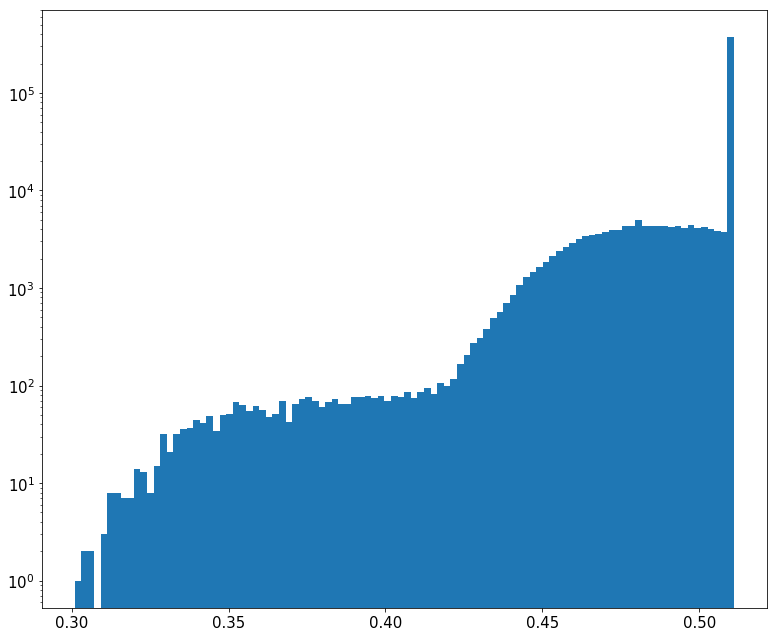

In [17]:
good_e = true_dep_e[sel_phot_like]
h = plt.hist(good_e, bins=100);
plt.yscale('log')

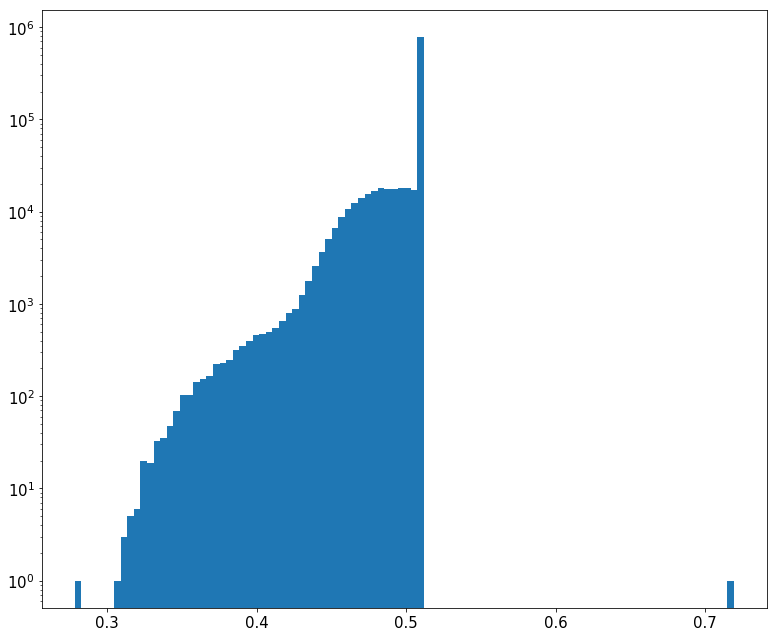

In [18]:
bad_e = true_dep_e[sel_compt_like]
h = plt.hist(bad_e, bins=100);
plt.yscale('log')

## Error matrices

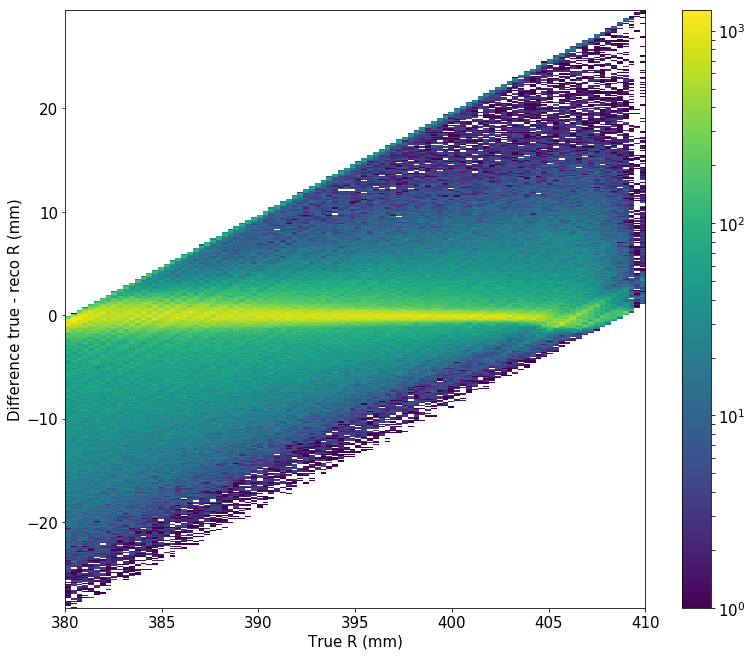

In [19]:
## all events
h_r, xedges_r, yedges_r, img_r = plt.hist2d(true_r, diff_r_matrix, bins=(100, 500), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True R (mm)');
plt.colorbar();
#plt.ylim(-5,5)

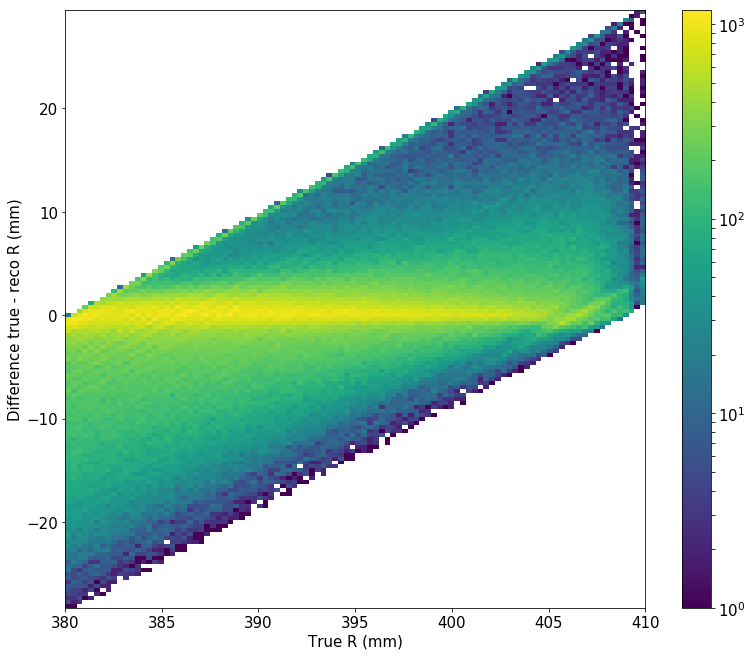

In [20]:
## not photoelectric-like events
h_r, xedges_r, yedges_r, img_r = plt.hist2d(true_r[sel_compt_like], \
                                            diff_r_matrix[sel_compt_like], \
                                            bins=(100, 150), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True R (mm)');
plt.colorbar();

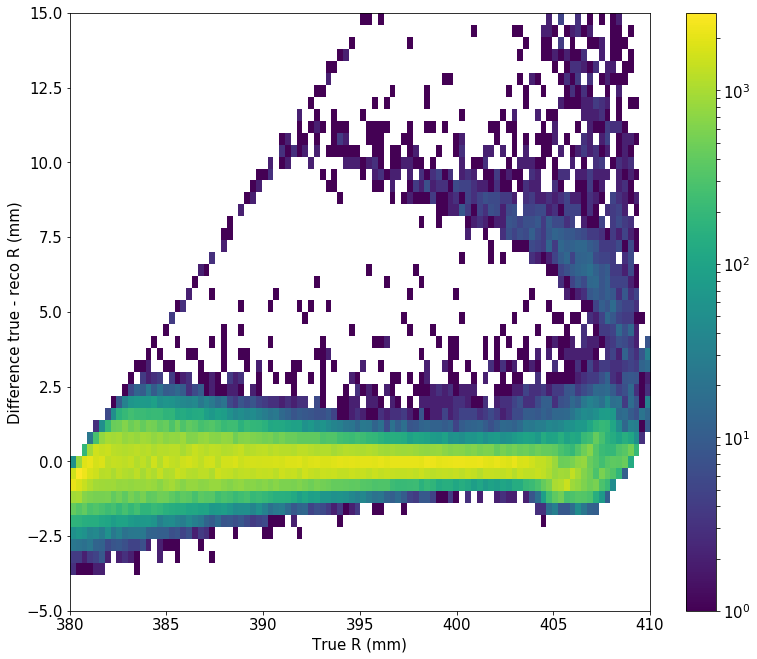

In [21]:
## photoelectric-like events
h_r, xedges_r, yedges_r, img_r = plt.hist2d(true_r[sel_phot_like], \
                                            diff_r_matrix[sel_phot_like], \
                                            bins=(100, 50), range=((380, 410), (-5, 15)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True R (mm)');
plt.colorbar();

In [22]:
# Save the error matrix for the fast MC.
#eff = len(true_z)/(len(D_true_z1) + len(D_true_z2)); eff = np.array(eff)
eff = np.array([1])
xmin = xedges_r[0]; xmin = np.array(xmin)
ymin = yedges_r[0]; ymin = np.array(ymin)
dx = xedges_r[1:]-xedges_r[:-1]; dx = np.array(dx[0])
dy = yedges_r[1:]-yedges_r[:-1]; dy = np.array(dy[0])
np.savez("errmat_r_compt_like.npz", errmat=h_r, eff=eff, xmin=xmin, ymin=ymin, dx=dx, dy=dy)

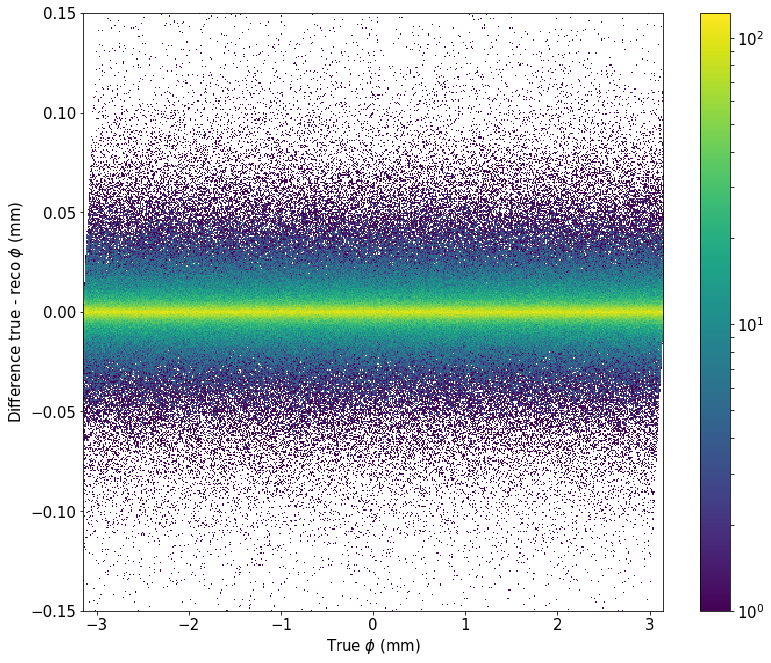

In [23]:
h_phi, xedges_phi, yedges_phi, img_phi = plt.hist2d(true_phi[sel_compt_like], diff_phi_matrix[sel_compt_like],
                                                    bins=(500, 500), range=((-3.15, 3.15), (-0.15, 0.15)), #cmin=1)
                                                    norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco $\phi$ (mm)')
plt.xlabel('True $\phi$ (mm)');
plt.colorbar();
#plt.ylim(-0.02, 0.02)

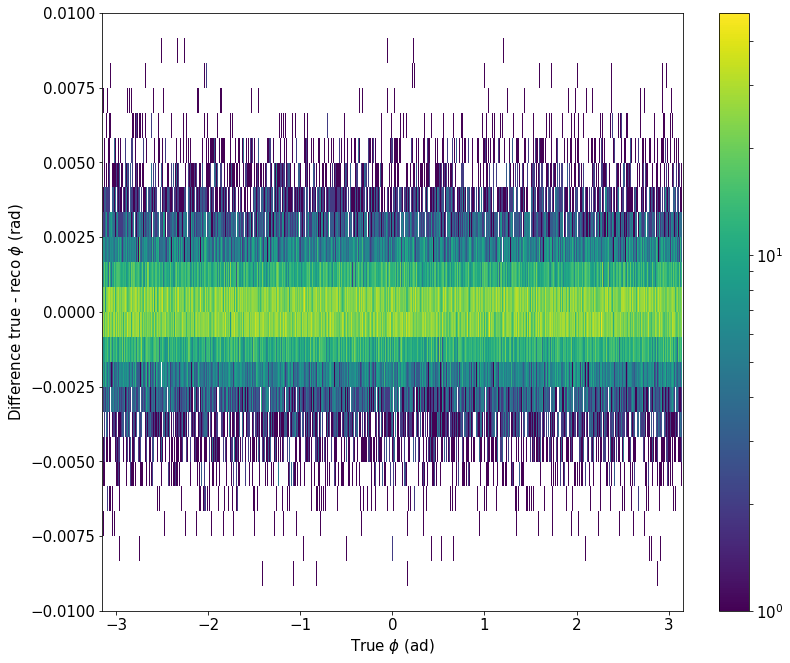

In [24]:
h_phi, xedges_phi, yedges_phi, img_phi = plt.hist2d(true_phi[sel_phot_like], diff_phi_matrix[sel_phot_like],
                                                    bins=(5166, 24), range=((-3.15, 3.15), (-0.01, 0.01)),# cmin=1)#,
                                                    norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco $\phi$ (rad)')
plt.xlabel('True $\phi$ (ad)');
plt.colorbar();

In [25]:
np.sum(h_phi,axis=1)

array([0., 0., 0., ..., 0., 0., 0.])

In [26]:
h_phi.shape

(5166, 24)

In [27]:
# Save the error matrix for the fast MC.
#eff = len(true_z)/(len(D_true_z1) + len(D_true_z2)); eff = np.array(eff)
eff = np.array([1])
xmin = xedges_phi[0]; xmin = np.array(xmin)
ymin = yedges_phi[0]; ymin = np.array(ymin)
dx = xedges_phi[1:]-xedges_phi[:-1]; dx = np.array(dx[0])
dy = yedges_phi[1:]-yedges_phi[:-1]; dy = np.array(dy[0])
np.savez("errmat_phi_compt_like.npz", errmat=h_phi, eff=eff, xmin=xmin, ymin=ymin, dx=dx, dy=dy)

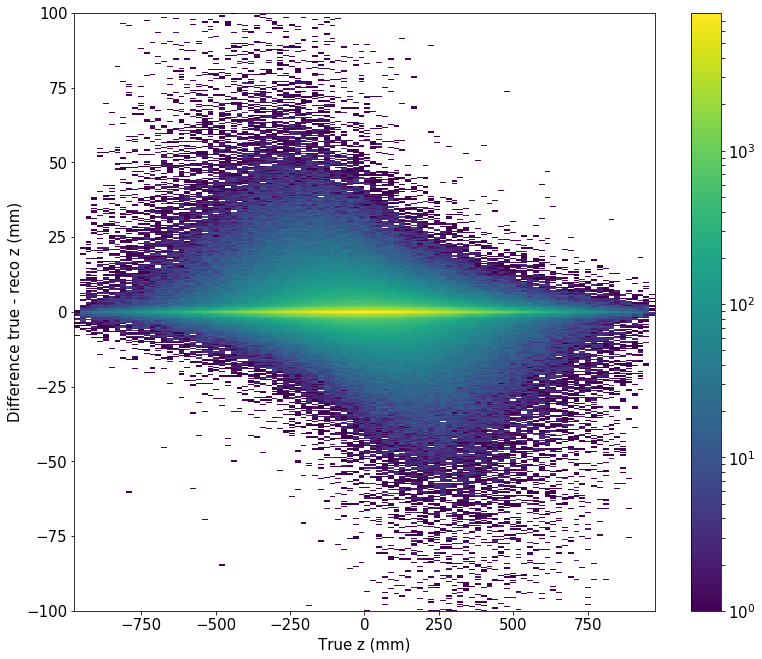

In [28]:
h_z, xedges_z, yedges_z, img_z = plt.hist2d(true_z, diff_z_matrix, bins=(100, 500),\
                                                    range=((-975, 975), (-100, 100)),norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco z (mm)')
plt.xlabel('True z (mm)');
plt.colorbar();


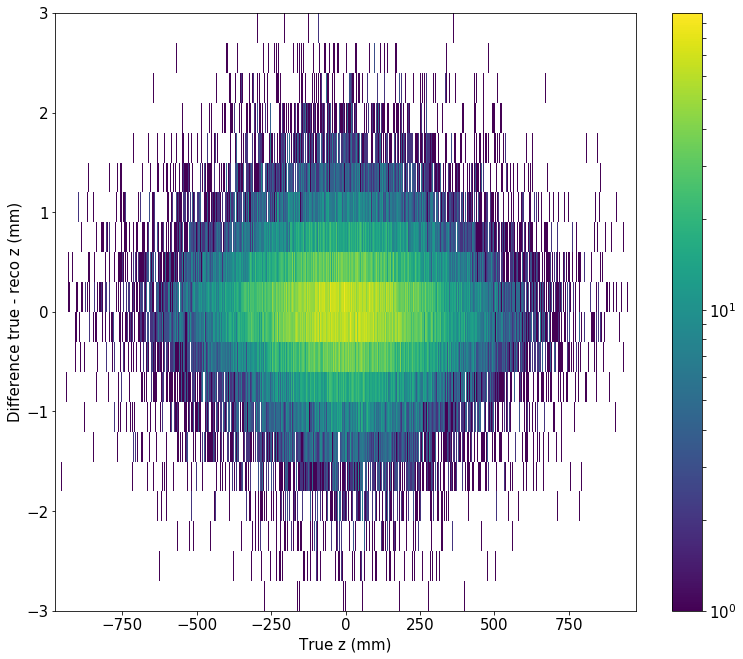

In [29]:
h_z, xedges_z, yedges_z, img_z = plt.hist2d(true_z[sel_phot_like], diff_z_matrix[sel_phot_like], bins=(6500, 20),\
                                                    range=((-975, 975), (-3, 3)),norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco z (mm)')
plt.xlabel('True z (mm)');
plt.colorbar();

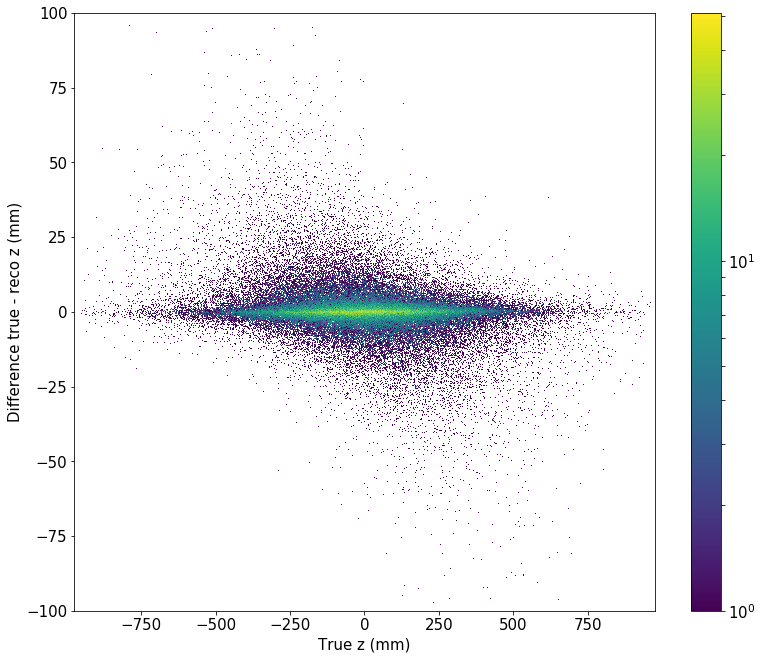

In [30]:
h_z, xedges_z, yedges_z, img_z = plt.hist2d(true_z[sel_compt_like], diff_z_matrix[sel_compt_like], bins=(6500, 667),\
                                                    range=((-975, 975), (-100, 100)),norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco z (mm)')
plt.xlabel('True z (mm)');
plt.colorbar();

In [31]:
# Save the error matrix for the fast MC.
#eff = len(true_z)/(len(D_true_z1) + len(D_true_z2)); eff = np.array(eff)
eff = np.array([1])
xmin = xedges_z[0]; xmin = np.array(xmin)
ymin = yedges_z[0]; ymin = np.array(ymin)
dx = xedges_z[1:]-xedges_z[:-1]; dx = np.array(dx[0])
dy = yedges_z[1:]-yedges_z[:-1]; dy = np.array(dy[0])
np.savez("errmat_z_compt_like.npz", errmat=h_z, eff=eff, xmin=xmin, ymin=ymin, dx=dx, dy=dy)

In [32]:
np.sum(h_z,axis=1)

array([0., 0., 0., ..., 0., 0., 0.])

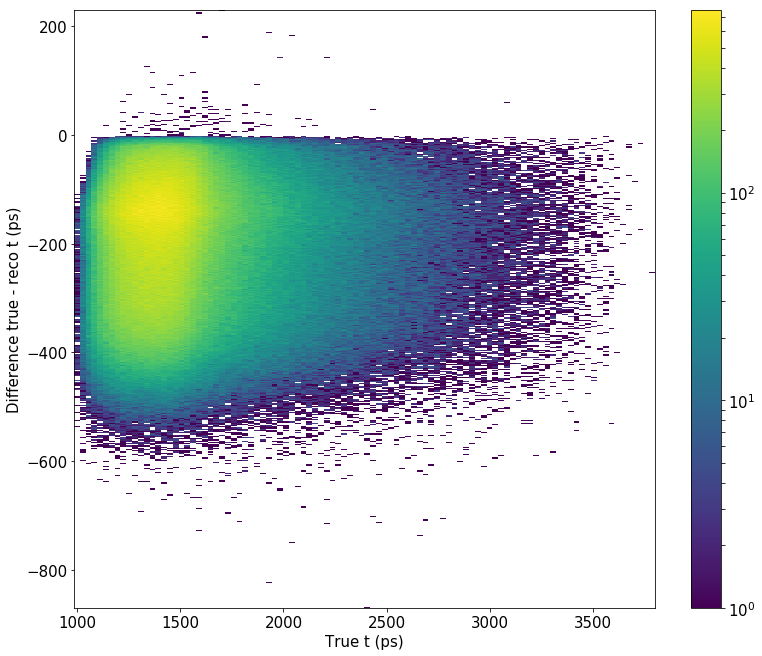

In [34]:
h_t, xedges_t, yedges_t, img_t = plt.hist2d(true_t, diff_t_matrix, bins=(100, 500),\
                                                    norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco t (ps)')
plt.xlabel('True t (ps)');
plt.colorbar();

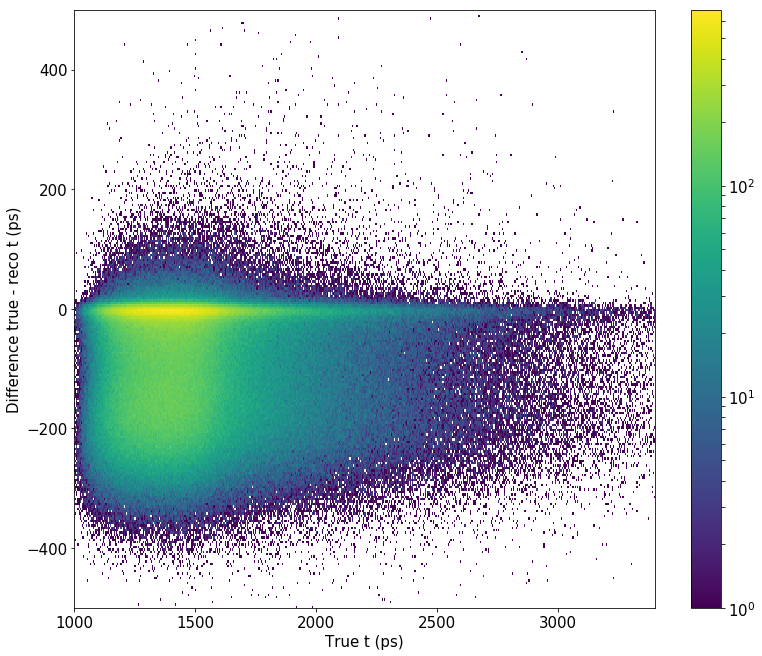

In [35]:
h_t, xedges_t, yedges_t, img_t = plt.hist2d(true_t, diff_reco_t_matrix, bins=(500, 250),\
                                                    range=((1000, 3400), (-500, 500)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco t (ps)')
plt.xlabel('True t (ps)');
plt.colorbar();
#plt.ylim(-10, 10)

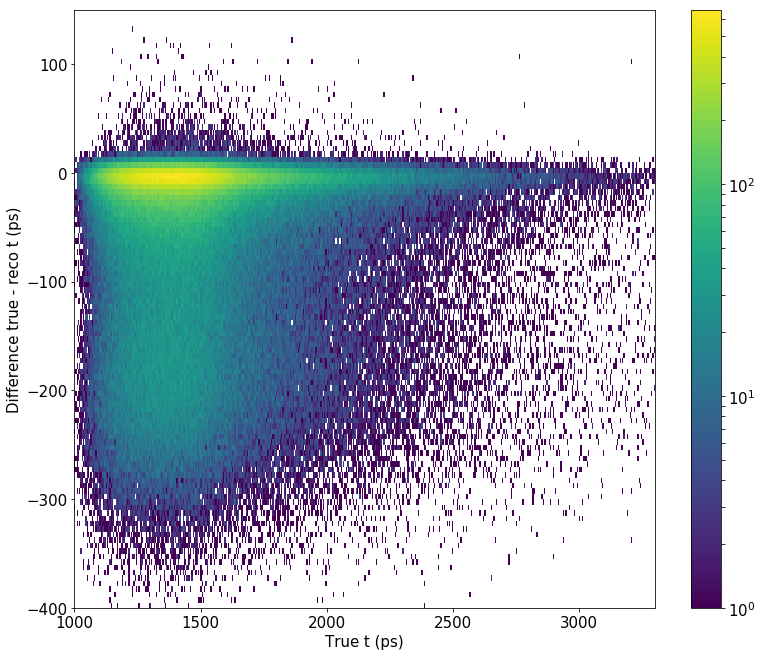

In [36]:
h_t, xedges_t, yedges_t, img_t = plt.hist2d(true_t[sel_phot_like], diff_reco_t_matrix[sel_phot_like], bins=(460, 110),\
                                                    range=((1000, 3300), (-400, 150)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco t (ps)')
plt.xlabel('True t (ps)');
plt.colorbar();

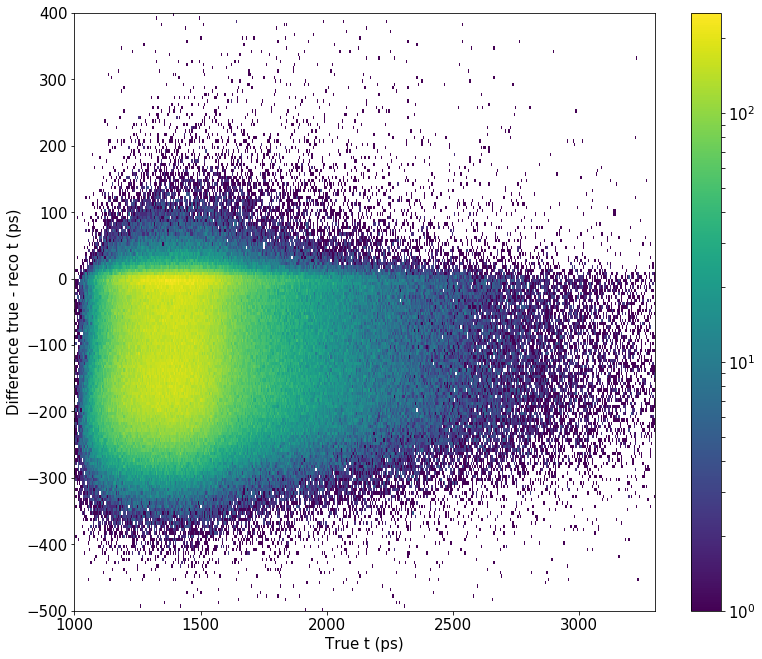

In [37]:
h_t, xedges_t, yedges_t, img_t = plt.hist2d(true_t[sel_compt_like], diff_reco_t_matrix[sel_compt_like], bins=(460, 180),\
                                                    range=((1000, 3300), (-500, 400)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco t (ps)')
plt.xlabel('True t (ps)');
plt.colorbar();

In [38]:
np.sum(h_t,axis=1)

array([  33.,   65.,   75.,  149.,  199.,  254.,  367.,  464.,  523.,
        640.,  733.,  966., 1096., 1173., 1330., 1604., 1728., 1944.,
       2096., 2275., 2506., 2782., 2894., 3009., 3218., 3441., 3645.,
       3956., 3846., 4232., 4432., 4719., 4831., 5091., 5092., 5316.,
       5640., 5671., 5867., 6086., 6180., 6447., 6441., 6784., 6740.,
       6899., 7089., 7122., 7167., 7384., 7446., 7579., 7642., 7858.,
       7927., 8184., 7984., 8112., 8312., 8339., 8391., 8421., 8544.,
       8509., 8570., 8657., 8640., 8850., 8795., 8859., 8785., 8722.,
       9038., 8975., 8821., 8968., 9143., 8910., 9119., 9164., 9113.,
       9055., 8985., 8998., 9061., 9019., 8788., 8762., 8915., 8814.,
       8676., 8714., 8454., 8478., 8451., 8278., 8278., 8125., 8291.,
       7880., 7875., 7793., 7646., 7624., 7363., 7377., 7175., 6881.,
       6766., 6837., 6452., 6366., 6131., 6174., 6030., 5675., 5570.,
       5311., 5216., 5091., 4943., 4746., 4608., 4654., 4313., 4263.,
       4183., 4111.,

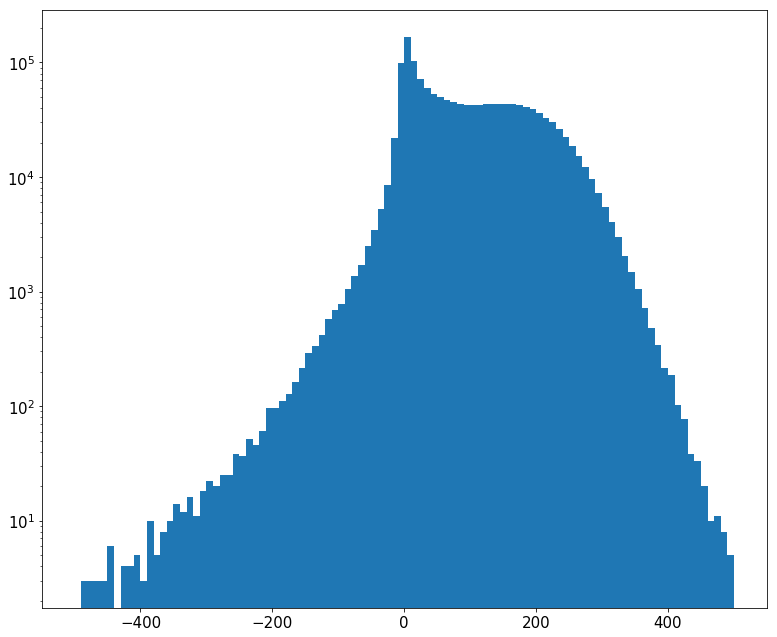

In [39]:
g = plt.hist(-diff_reco_t_matrix, bins=100, range=(-500, 500))
plt.yscale('log')

In [40]:
# Save the error matrix for the fast MC.
#eff = len(true_t)/(len(D_true_t1) + len(D_true_t2)); eff = np.array(eff)
eff = np.array([1])
xmin = xedges_t[0]; xmin = np.array(xmin)
ymin = yedges_t[0]; ymin = np.array(ymin)
dx = xedges_t[1:]-xedges_t[:-1]; dx = np.array(dx[0])
dy = yedges_t[1:]-yedges_t[:-1]; dy = np.array(dy[0])
np.savez("errmat_t_compt_like.npz", errmat=h_t, eff=eff, xmin=xmin, ymin=ymin, dx=dx, dy=dy)

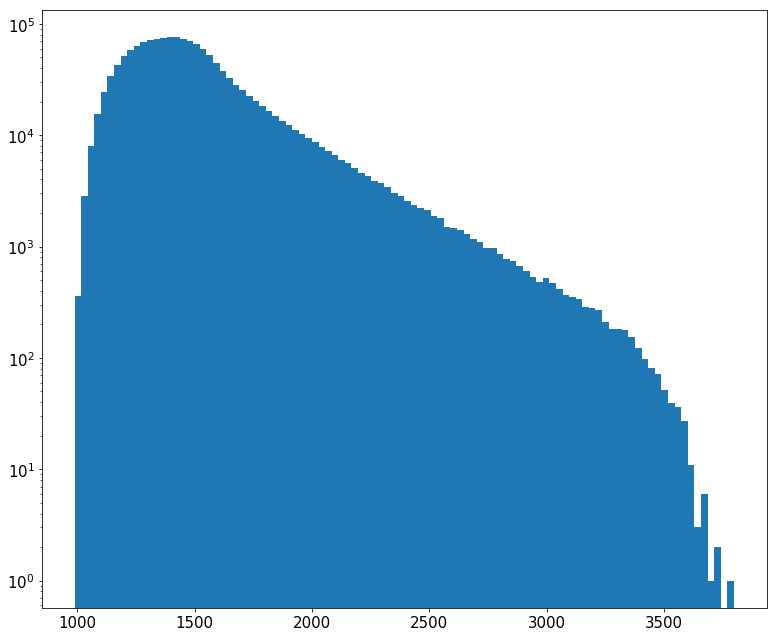

In [41]:
h = plt.hist(true_t, bins=100)
plt.yscale('log');

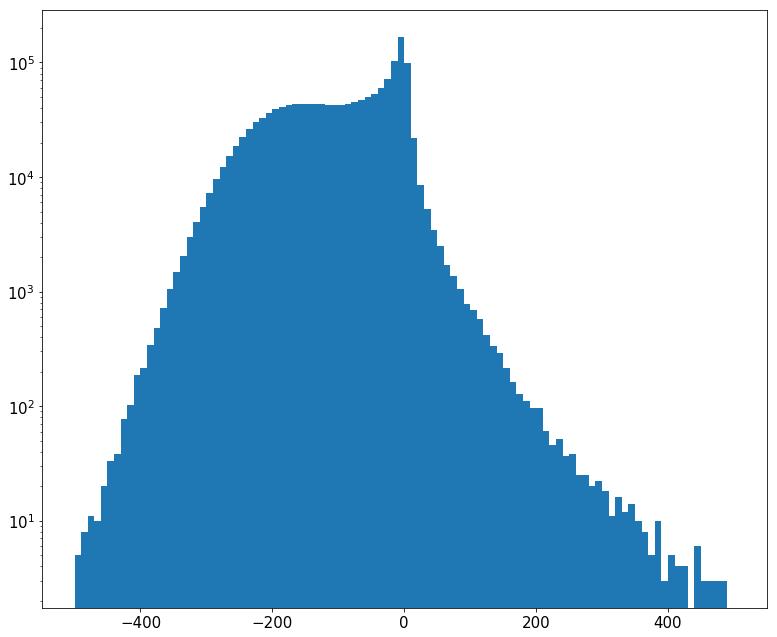

In [42]:
h = plt.hist(diff_reco_t_matrix, bins=100, range=(-500, 500))
plt.yscale('log');

## Correlations

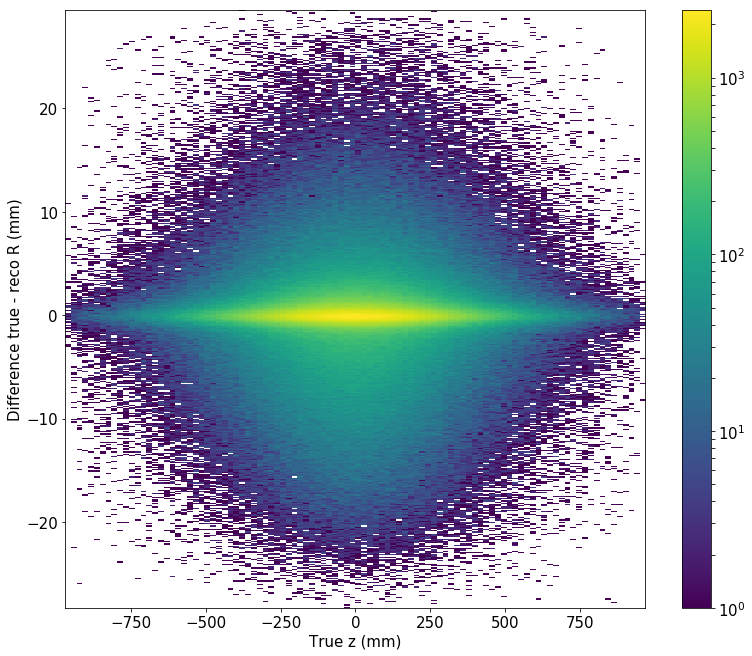

In [43]:
plt.hist2d(true_z, diff_r_matrix, bins=(100, 500), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True z (mm)');
plt.colorbar();

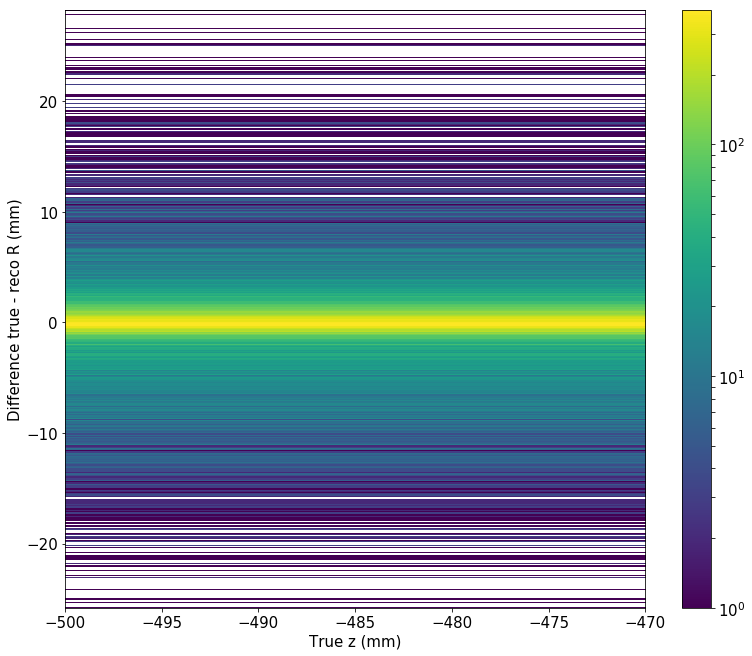

In [44]:
slice1    = (true_z>-500) & (true_z<-470)
z_sl1     = true_z[slice1]
err_r_sl1 = diff_r_matrix[slice1]

h1, xedges, yedges, img = plt.hist2d(z_sl1, err_r_sl1, bins=(1, 500), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True z (mm)');
plt.colorbar();

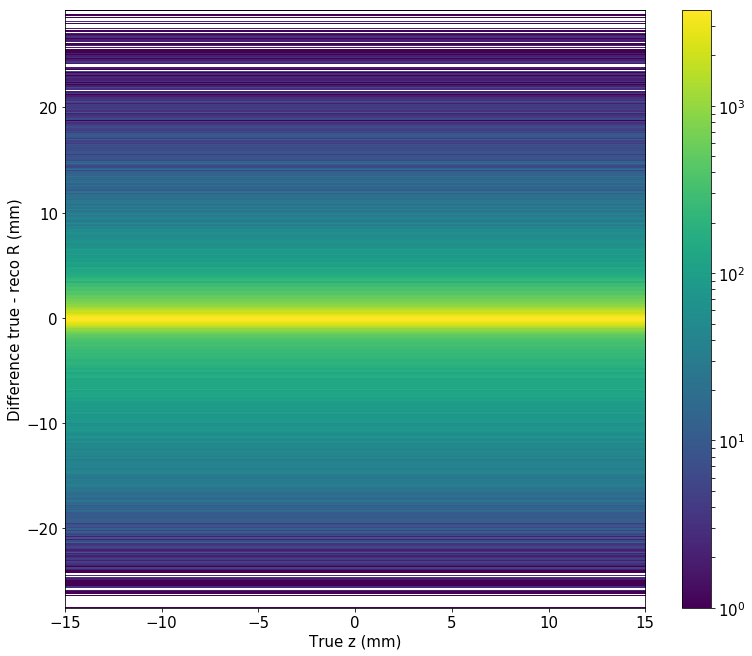

In [45]:
slice2    = (true_z>-15) & (true_z<15)
z_sl2     = true_z[slice2]
err_r_sl2 = diff_r_matrix[slice2]

h2, xedges, yedges, img = plt.hist2d(z_sl2, err_r_sl2, bins=(1, 500), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True z (mm)');
plt.colorbar();

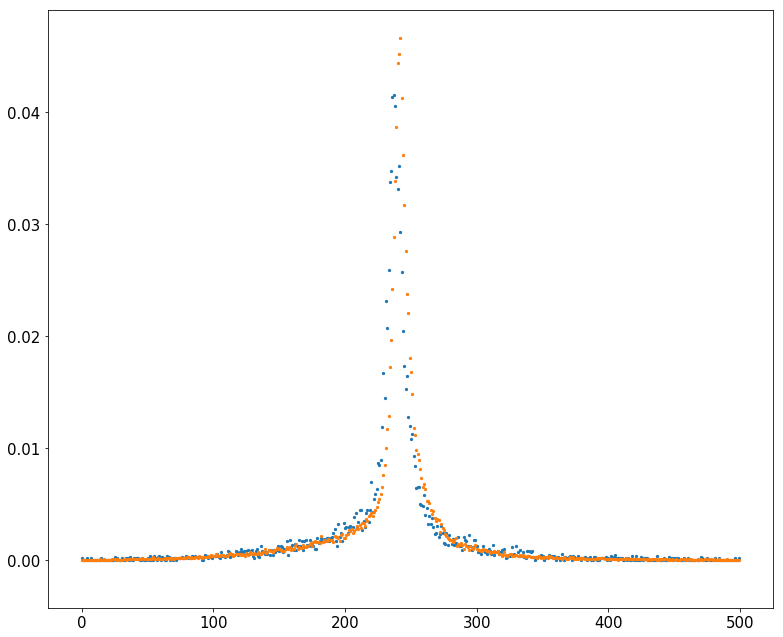

In [46]:
plt.scatter(list(range(len(h1[0]))), h1[0]/h1[0].sum(), s=5)
plt.scatter(list(range(len(h2[0]))), h2[0]/h2[0].sum(), s=5)

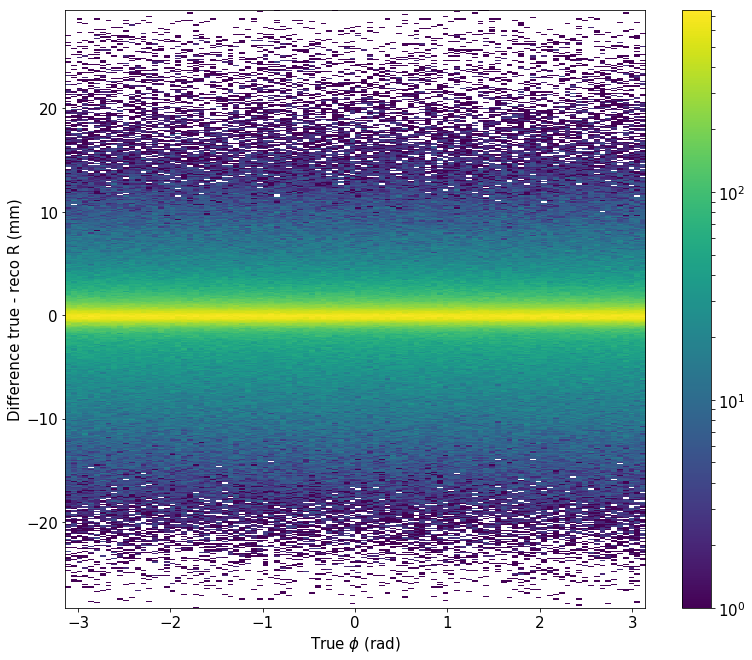

In [47]:
plt.hist2d(true_phi, diff_r_matrix, bins=(100, 500), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True $\phi$ (rad)');
plt.colorbar();

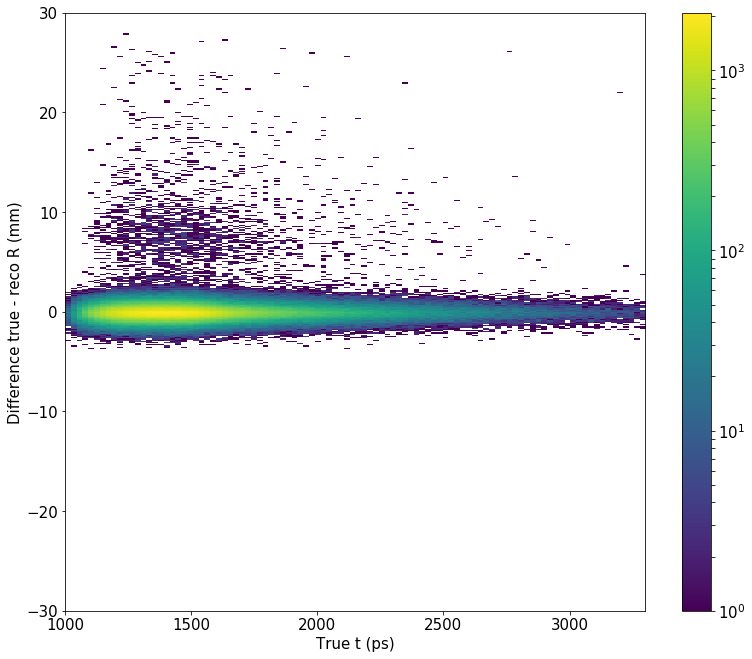

In [48]:
plt.hist2d(true_t[sel_phot_like], diff_r_matrix[sel_phot_like], bins=(100, 500), range=((1000, 3300), (-30, 30)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True t (ps)');
plt.colorbar();

In [49]:
true_t[sel_phot_like & (true_t>1500) & (true_t<1510) & (true_r>390) & (true_r<390.2)]

array([1506.74247742, 1509.82236862, 1506.86740875, 1509.99772549,
       1509.58836079, 1501.38390064, 1508.05640221, 1503.83746624,
       1509.57763195, 1503.17776203, 1500.07224083, 1509.98330116,
       1503.50832939, 1508.32307339, 1509.03820992, 1507.70306587,
       1502.13003159, 1508.56995583, 1506.24787807, 1502.19130516,
       1506.43062592, 1504.4554472 , 1501.6862154 , 1504.93299961,
       1509.83226299, 1504.01246548, 1502.83741951, 1508.64982605,
       1500.80740452, 1508.81958008, 1501.21855736, 1504.79078293,
       1503.54969501, 1509.31227207, 1507.69650936, 1502.19738483,
       1505.97310066, 1506.11019135, 1506.29329681, 1503.3339262 ,
       1508.73172283, 1506.20853901, 1503.40235233, 1506.9180727 ,
       1500.35381317, 1506.49046898, 1506.9206953 , 1508.55243206,
       1505.81586361, 1503.67558002, 1502.15566158, 1506.00910187,
       1503.62741947, 1503.15666199, 1500.03373623, 1505.38885593,
       1506.03377819, 1508.17406178, 1506.07228279, 1503.27301

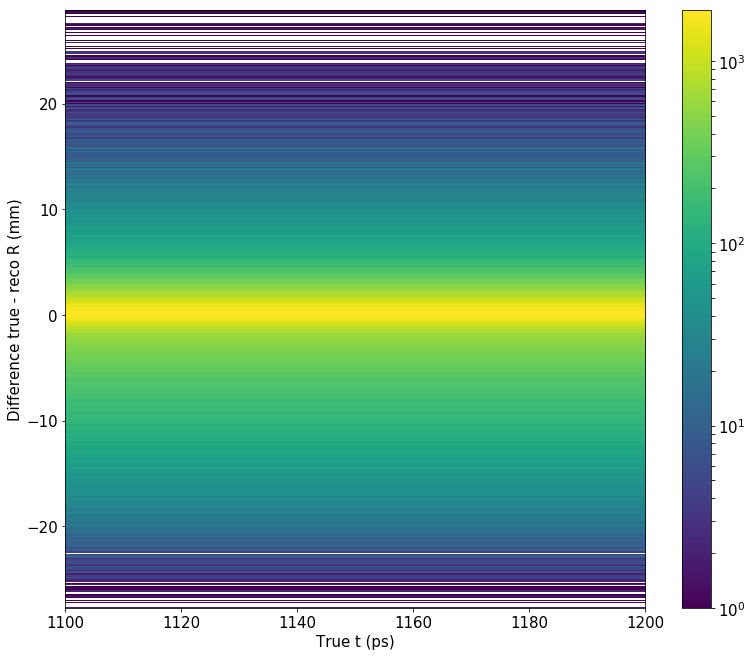

In [50]:
slice1    = (true_t>1100) & (true_t<1200) & sel_compt_like
t_sl1     = true_t[slice1]
err_r_sl1 = diff_r_matrix[slice1]

h1, xedges, yedges, img = plt.hist2d(t_sl1, err_r_sl1, bins=(1, 500), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True t (ps)');
plt.colorbar();

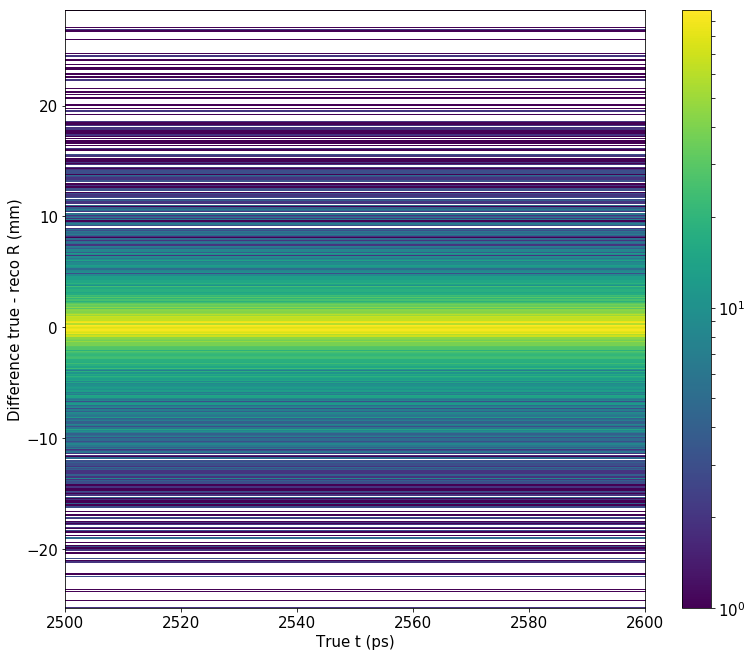

In [51]:
slice2    = (true_t>2500) & (true_t<2600) & sel_compt_like
t_sl2     = true_t[slice2]
err_r_sl2 = diff_r_matrix[slice2]

h2, xedges, yedges, img = plt.hist2d(t_sl2, err_r_sl2, bins=(1, 500), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True t (ps)');
plt.colorbar();

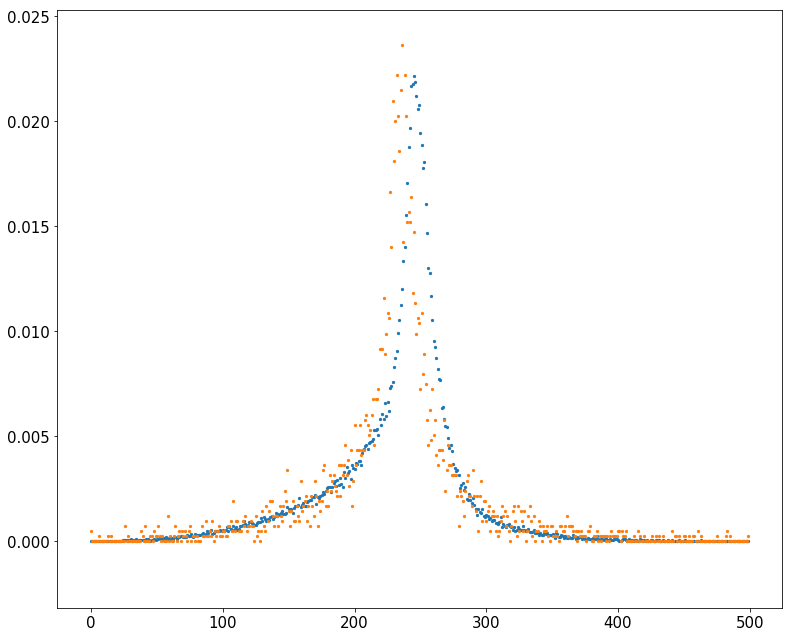

In [52]:
plt.scatter(list(range(len(h1[0]))), h1[0]/h1[0].sum(), s=5)
plt.scatter(list(range(len(h2[0]))), h2[0]/h2[0].sum(), s=5)

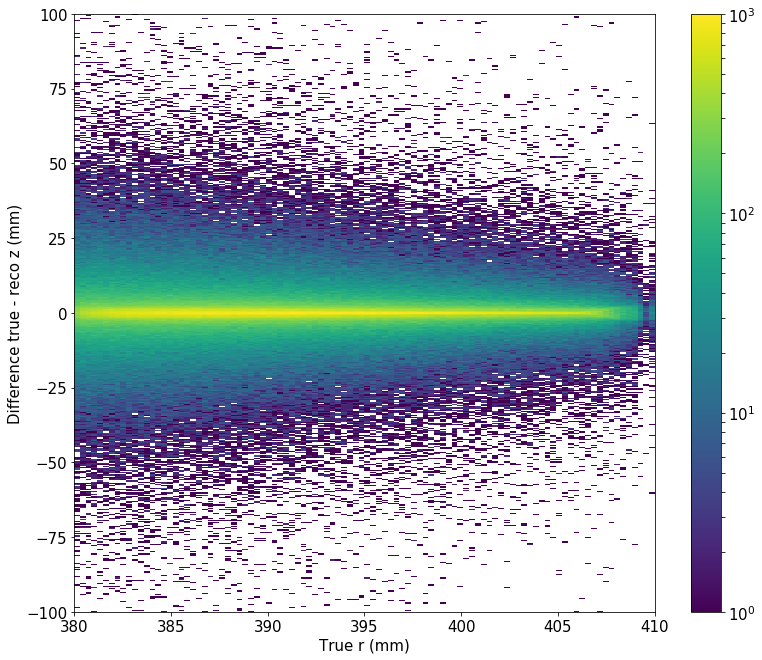

In [53]:
plt.hist2d(true_r[sel_compt_like], diff_z_matrix[sel_compt_like], bins=(100, 500), \
           range=((380, 410), (-100, 100)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco z (mm)')
plt.xlabel('True r (mm)');
plt.colorbar();

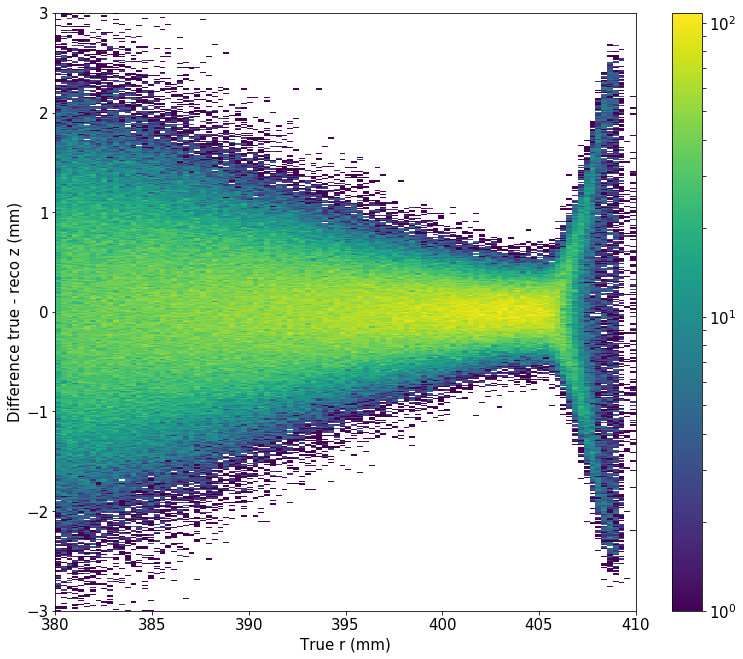

In [54]:
plt.hist2d(true_r[sel_phot_like], diff_z_matrix[sel_phot_like], bins=(100, 500), \
           range=((380, 410), (-3, 3)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco z (mm)')
plt.xlabel('True r (mm)');
plt.colorbar();

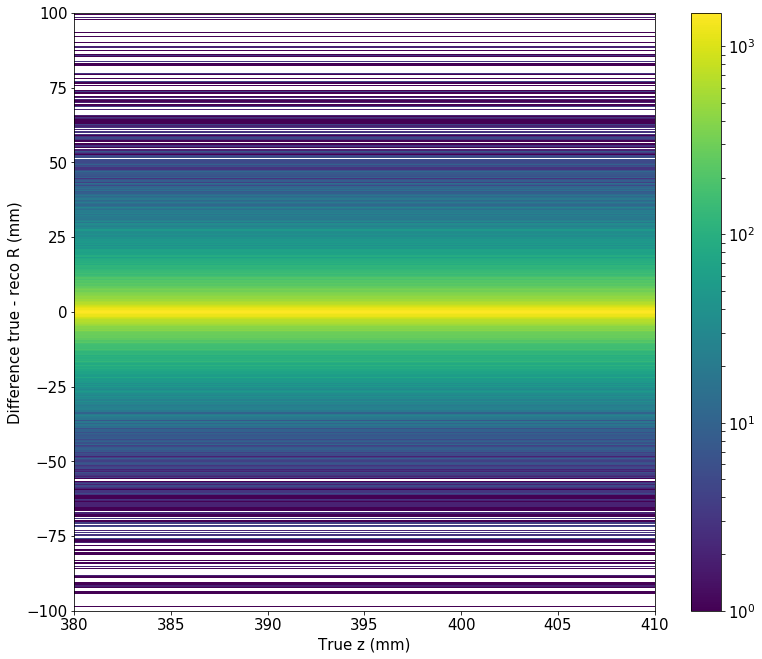

In [55]:
slice1    = (true_r>380) & (true_r<381) & sel_compt_like
r_sl1     = true_r[slice1]
err_z_sl1 = diff_z_matrix[slice1]

h1, xedges, yedges, img = plt.hist2d(r_sl1, err_z_sl1, bins=(1, 500), range=((380, 410), (-100, 100)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True z (mm)');
plt.colorbar();

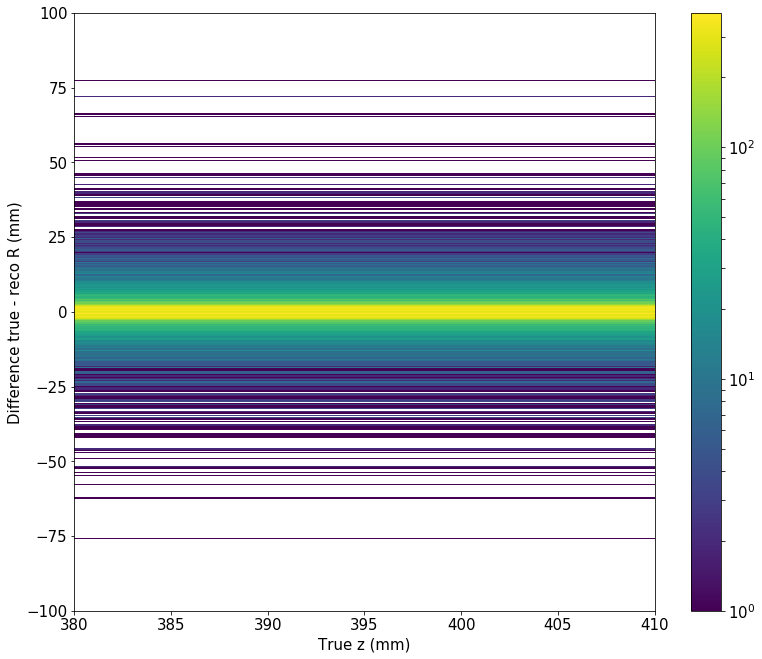

In [56]:
slice2    = (true_r>408) & (true_r<409) & sel_compt_like
r_sl2     = true_r[slice2]
err_z_sl2 = diff_z_matrix[slice2]

h2, xedges, yedges, img = plt.hist2d(r_sl2, err_z_sl2, bins=(1, 500), range=((380, 410), (-100, 100)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True z (mm)');
plt.colorbar();

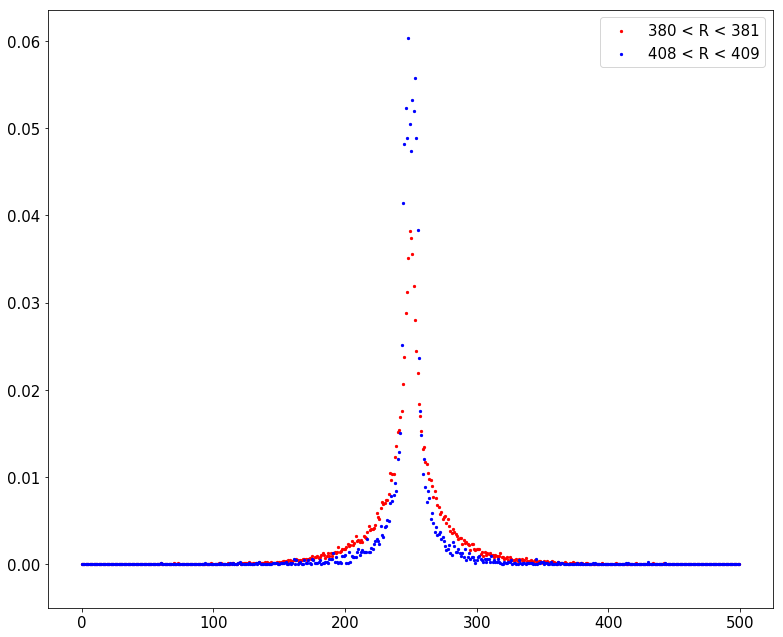

In [57]:
plt.scatter(list(range(len(h1[0]))), h1[0]/h1[0].sum(), s=5, c= 'red', label='380 < R < 381')
plt.scatter(list(range(len(h2[0]))), h2[0]/h2[0].sum(), s=5, c='blue', label='408 < R < 409')
plt.legend(loc=1)

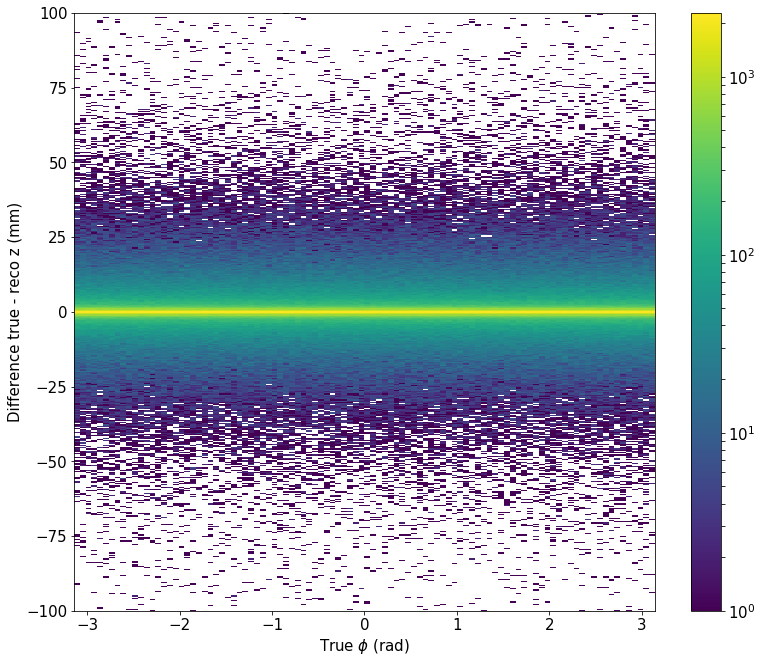

In [58]:
plt.hist2d(true_phi, diff_z_matrix, bins=(100, 500), range=((-3.14, 3.14), (-100, 100)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco z (mm)')
plt.xlabel('True $\phi$ (rad)');
plt.colorbar();

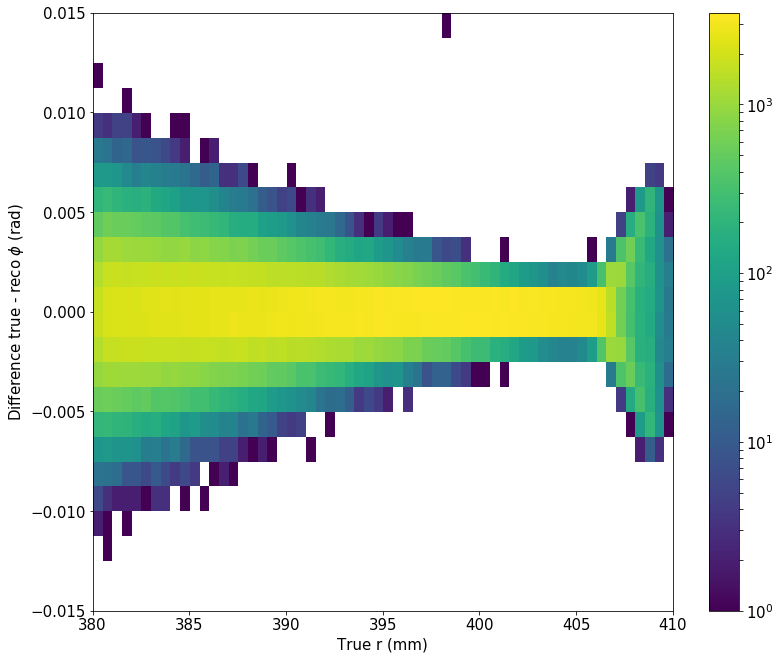

In [59]:
plt.hist2d(true_r[sel_phot_like], diff_phi_matrix[sel_phot_like], bins=(60, 24), 
           range=((380, 410), (-0.015, 0.015)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco $\phi$ (rad)')
plt.xlabel('True r (mm)');
plt.colorbar();

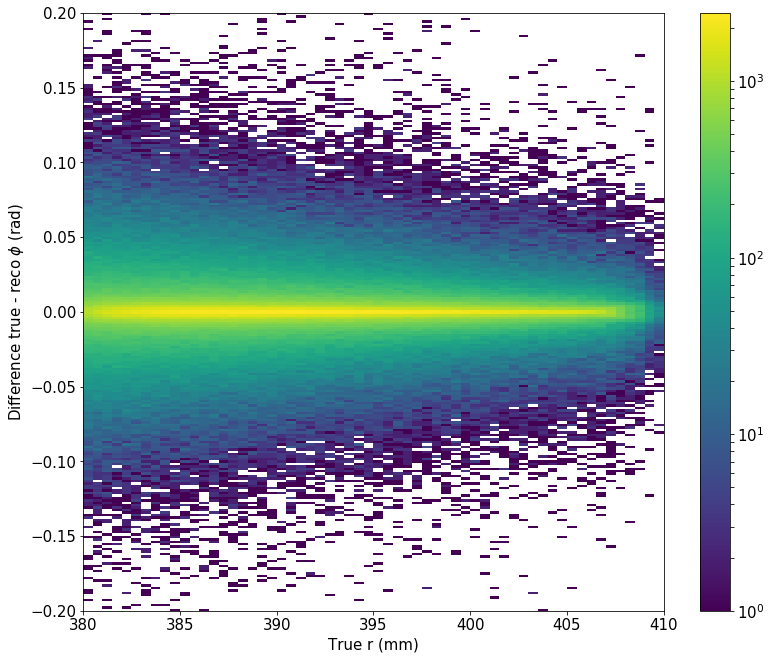

In [60]:
plt.hist2d(true_r[sel_compt_like], diff_phi_matrix[sel_compt_like], bins=(60, 246), 
           range=((380, 410), (-0.2, 0.2)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco $\phi$ (rad)')
plt.xlabel('True r (mm)');
plt.colorbar();

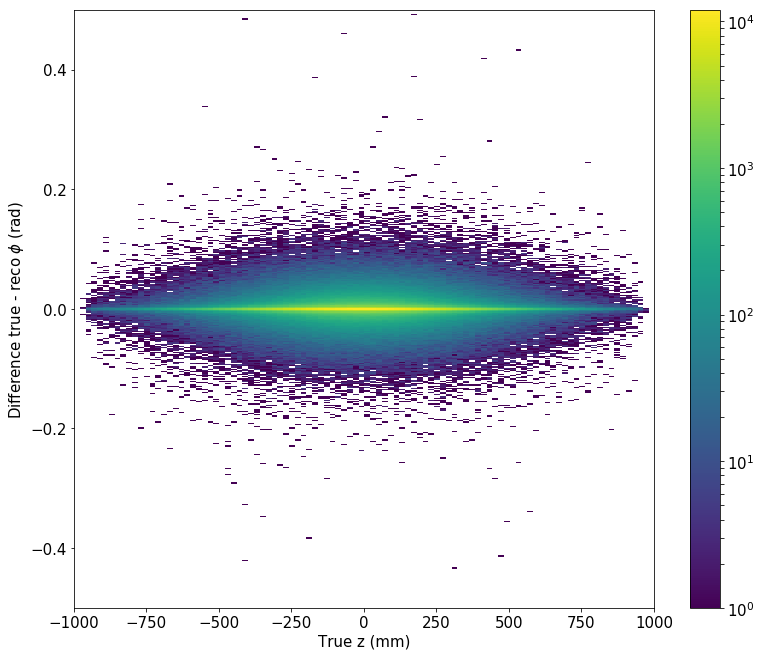

In [61]:
plt.hist2d(true_z, diff_phi_matrix, bins=(100, 500), range=((-1000, 1000), (-0.5, 0.5)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco $\phi$ (rad)')
plt.xlabel('True z (mm)');
plt.colorbar();

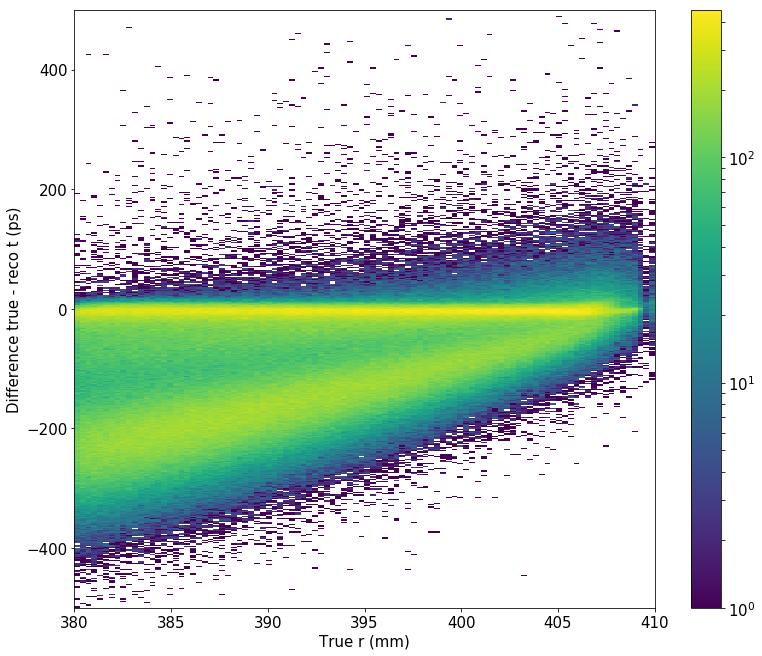

In [62]:
plt.hist2d(true_r, diff_reco_t_matrix, bins=(100, 500), range=((380, 410), (-500, 500)), norm=mp_colors.LogNorm())
plt.xlabel('True r (mm)');
plt.ylabel('Difference true - reco t (ps)')
plt.colorbar();

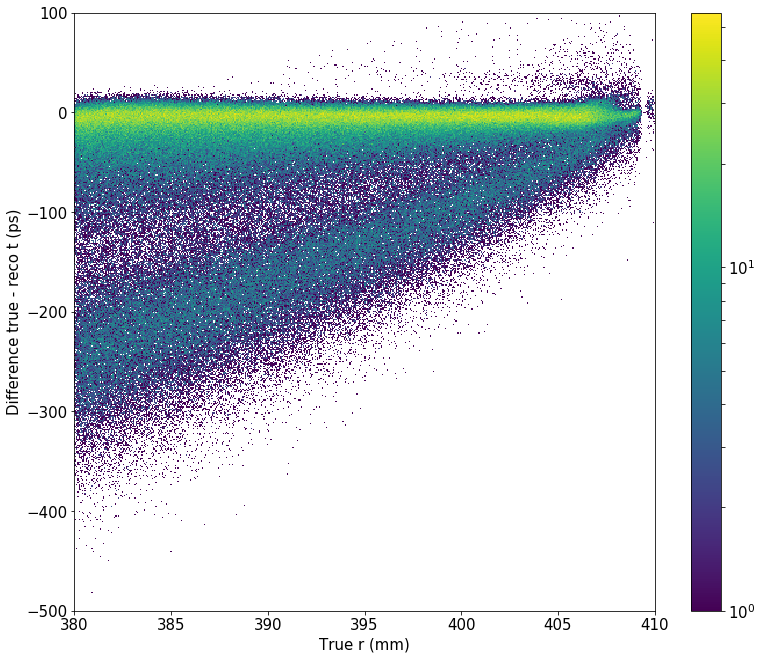

In [63]:
plt.hist2d(true_r[sel_phot_like], \
           diff_reco_t_matrix[sel_phot_like], \
           bins=(500, 500), range=((380, 410), (-500, 100)), norm=mp_colors.LogNorm())
plt.xlabel('True r (mm)');
plt.ylabel('Difference true - reco t (ps)')
plt.colorbar();

In [64]:
var = true_t2 - reco_t2
phot_evts = events[phot2 == True]
print(phot_evts[var[phot2 == True] < -200])

[28860090. 28861521. 28890806. ... 89131951. 89161839. 89162500.]


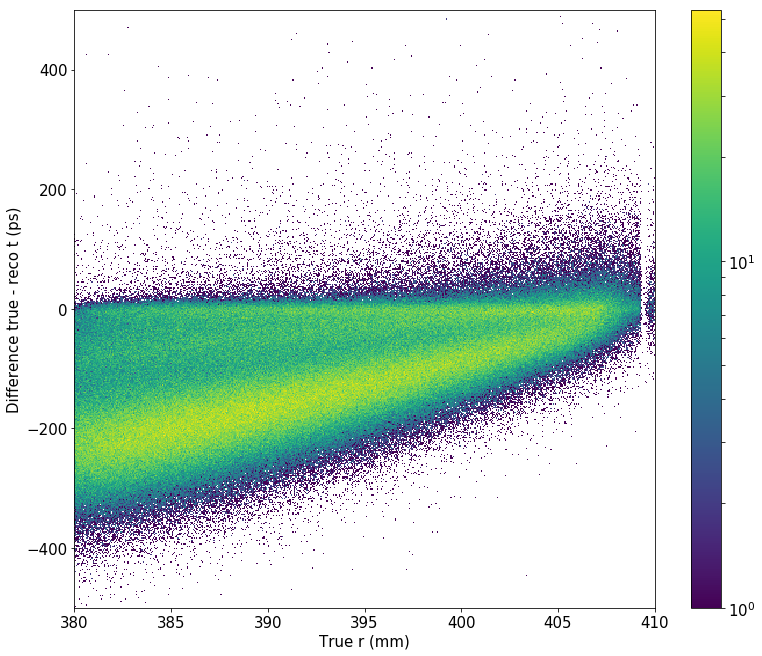

In [65]:
plt.hist2d(true_r[sel_compt_like], \
           diff_reco_t_matrix[sel_compt_like], \
           bins=(500, 500), range=((380, 410), (-500, 500)), norm=mp_colors.LogNorm())
plt.xlabel('True r (mm)');
plt.ylabel('Difference true - reco t (ps)')
plt.colorbar();

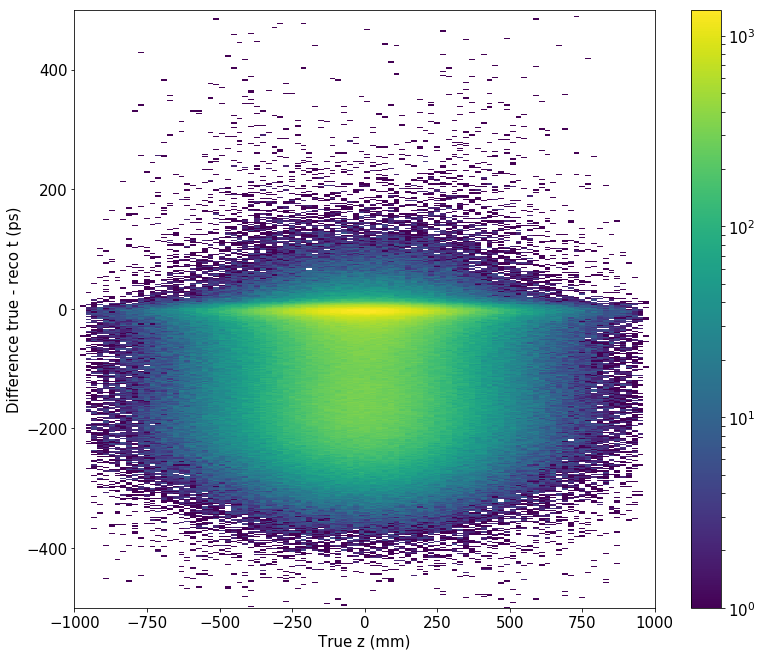

In [66]:
plt.hist2d(true_z, diff_reco_t_matrix, bins=(100, 500), range=((-1000, 1000), (-500, 500)), norm=mp_colors.LogNorm())
plt.xlabel('True z (mm)');
plt.ylabel('Difference true - reco t (ps)')
plt.colorbar();

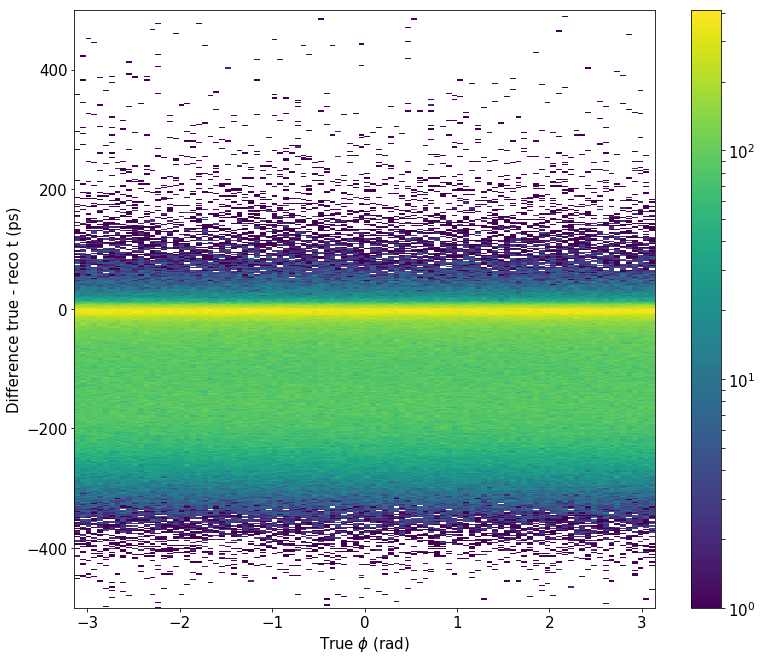

In [67]:
plt.hist2d(true_phi, diff_reco_t_matrix, bins=(100, 500), range=((-3.14, 3.14), (-500, 500)), norm=mp_colors.LogNorm())
plt.xlabel('True $\phi$ (rad)');
plt.ylabel('Difference true - reco t (ps)')
plt.colorbar();

## True-true correlation

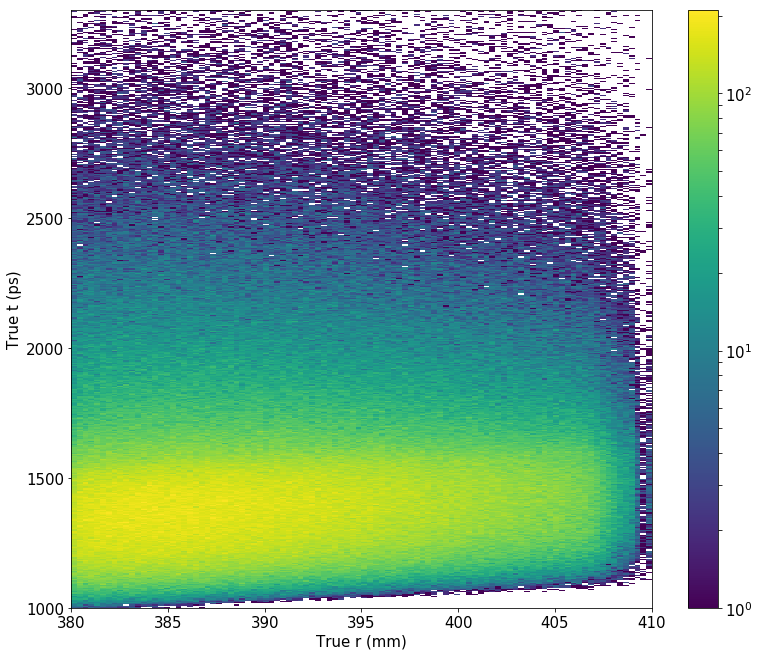

In [68]:
plt.hist2d(true_r, true_t, bins=(100, 500), range=((380, 410), (1000, 3300)), norm=mp_colors.LogNorm())
plt.xlabel('True r (mm)')
plt.ylabel('True t (ps)')
plt.colorbar();

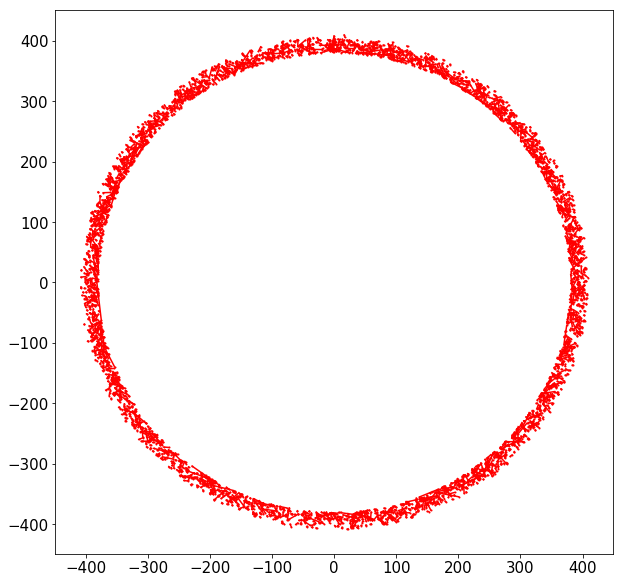

In [69]:
fig = plt.figure(1)
fig.set_figwidth(10.)
fig.set_figheight(10)

for i in range(2000, 5000):
    my_x, my_y = [], []
    my_x.append(reco_x[i:i+1])
    my_x.append(true_x[i:i+1])
    my_y.append(reco_y[i:i+1])
    my_y.append(true_y[i:i+1])
    plt.plot(my_x, my_y, 'ro-', markersize=1)
    
plt.show()